In [2]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

In [105]:
import os
import glob

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from utilities import *

sns.set_palette(CUSTOM_PALETTES["custom_dark"])
sns.set_palette("tab10")

In [49]:
DATA_DIR = "transparent_california_data"
data_paths = glob.glob(os.path.join(DATA_DIR, "university-of-california-*.csv"))
PHYSICIAN_SALARY_DATA_PATH = os.path.join(DATA_DIR, "physcian_salaries.csv")
PHYSICIAN_JOB_TITLES_PATH = os.path.join(DATA_DIR, "physician_job_titles.txt")

In [50]:
def load_physician_job_titles():
    """"""
    with open(PHYSICIAN_JOB_TITLES_PATH) as file:
        return sorted(set([title.lower() for title in file.read().split("\n")]))
    
physician_job_titles = load_physician_job_titles()

In [51]:
def clean_name(name: str) -> str:
    """"""
    name = name.lower()
    name = name.strip(", md").strip(", dr.")
    if "," in name:
        splits = name.split(",")
        if len(splits) > 2:
            return name
        assert len(splits) == 2, f"Should only have one , in name if any. {name}"
        name = splits[1].strip() + " " + splits[0].strip()
    return name

In [52]:
import gender_guesser.detector as gender
gd = gender.Detector(case_sensitive=False)

GENDER_REMAP = {
    "female": "Women",
    "mostly_female": "Mostly Women",
    "andy": "Androgenous",
    "unknown": "Unknown",
    "mostly_male": "Mostly Men",
    "male": "Men",
}

GENDER_SORT_KEY = dict(zip(GENDER_REMAP.values(), range(len(GENDER_REMAP))))
gender_sort_function = np.vectorize(GENDER_SORT_KEY.get)


def guess_gender(name: str) -> str:
    """"""
    first_name = name.split(" ")[0]
    return GENDER_REMAP.get(gd.get_gender(first_name))

In [53]:
def load_salary_data(data_path: str) -> pd.DataFrame:
    """"""
    if isinstance(data_path, str):
        salary_data = pd.read_csv(data_path, low_memory=False)
        salary_data.columns = [col.lower().strip().replace(" ", "_") for col in salary_data.columns]
        salary_data["pension_debt"] = 0
        salary_data.drop(columns=["pension_debt", "notes", "status", "agency"], inplace=True)
        salary_data.query('base_pay > 50_000', inplace=True)
        salary_data["employee_name"] = salary_data["employee_name"].apply(clean_name)
        salary_data.query("employee_name != 'not provided'", inplace=True)
        salary_data["gender"] = salary_data["employee_name"].apply(guess_gender)
        salary_data["job_title"] = salary_data["job_title"].str.lower()
        return salary_data
    
    return pd.concat([load_salary_data(data_path_i) for data_path_i in data_path])

In [54]:
def load_physician_salary_data(overwrite: bool = False) -> pd.DataFrame:
    """"""
    if os.path.exists(PHYSICIAN_SALARY_DATA_PATH) and not overwrite:
        physician_salary_data = pd.read_csv(PHYSICIAN_SALARY_DATA_PATH)
    else:
        all_salary_data = load_salary_data(data_paths)
        physician_salary_data = all_salary_data.loc[all_salary_data["job_title"].isin(physician_job_titles)]
        physician_salary_data.to_csv(PHYSICIAN_SALARY_DATA_PATH, index=False)
    
    return physician_salary_data

In [55]:
def metric_sort(data, variable, group, metric=np.median, return_sort_dict: bool = True):
    """"""
    variable = if_str_map(variable, data)
    group = if_str_map(group, data)
    
    sort_values = np.zeros(len(variable))
    sort_dict = {}
    for group_i in np.unique(group):
        group_index = group == group_i
        metric_value = metric(variable[group_index])
        sort_values[group_index] = metric_value
        sort_dict[group_i] = metric_value
    
    if return_sort_dict:
        return data.iloc[np.argsort(sort_values)], sort_dict
    return data.iloc[np.argsort(sort_values)]

In [56]:
salary_data = load_salary_data(data_paths)
salary_data["gender_normed_pay"] = salary_data["total_pay"] / np.median(salary_data.query("gender == 'Men'")["total_pay"])

In [106]:
def set_money_axis(axis):
    axis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))

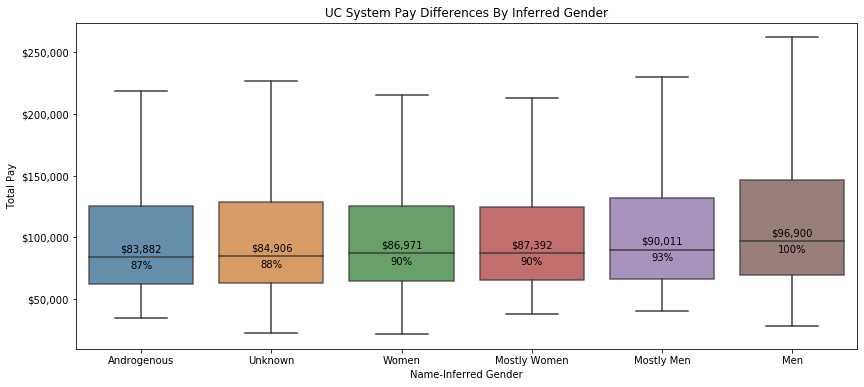

In [107]:
data, gender_medians = metric_sort(salary_data, "total_pay", "gender")

fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=data, x="gender", y="total_pay", showfliers=False, saturation=.6, boxprops=dict(alpha=.8))
add_plt_labels(ax, x="Name-Inferred Gender", y="Total Pay", title="UC System Pay Differences by Inferred Gender")
set_money_axis(ax.yaxis)

for i, gender in enumerate(pd.unique(data["gender"])):
    median = gender_medians[gender]
    median_percent = median / gender_medians["Men"] * 100
    ax.text(i, median * 1.03, f"${median:,.0f}", ha="center", va="bottom")
    ax.text(i, median * .97, f"{median_percent:,.0f}%", ha="center", va="top")

In [111]:
physician_salary_data = load_physician_salary_data()

In [120]:
is_resident = physician_salary_data["job_title"].str.contains("resid phys")
is_instr = physician_salary_data["job_title"].str.contains("instr")
is_attending = ~(is_resident | is_instr)

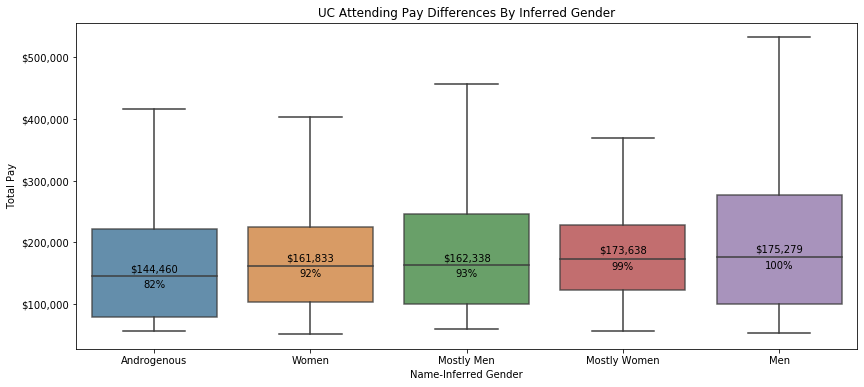

In [124]:
data = physician_salary_data.loc[is_instr].query("gender != 'Unknown'")
data, gender_medians = metric_sort(data, "total_pay", "gender")

fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=data, x="gender", y="total_pay", showfliers=False, saturation=.6, boxprops=dict(alpha=.8))
add_plt_labels(ax, x="Name-Inferred Gender", y="Total Pay", title="UC Attending Pay Differences by Inferred Gender")
set_money_axis(ax.yaxis)

for i, gender in enumerate(pd.unique(data["gender"])):
    median = gender_medians[gender]
    median_percent = median / gender_medians["Men"] * 100
    ax.text(i, median * 1.03, f"${median:,.0f}", ha="center", va="bottom")
    ax.text(i, median * .97, f"{median_percent:,.0f}%", ha="center", va="top")

In [10]:
is_resident = physician_salary_data["job_title"].str.contains("resid phys")
is_instr = physician_salary_data["job_title"].str.contains("instr")
is_attending = ~(is_resident | is_instr)

resident_data = physician_salary_data.loc[is_resident].query("year == 2019")
attending_data = physician_salary_data.loc[is_attending].query("year > 2018")

In [11]:
resident_names = resident_data["employee_name"]
resident_and_attending_names = resident_names.loc[resident_names.isin(attending_data["employee_name"])]

repeat_data = physician_salary_data.loc[physician_salary_data["employee_name"].isin(resident_and_attending_names)].sort_values(["employee_name", "year"])
duplicated_names = repeat_data["employee_name"].loc[repeat_data.duplicated(["employee_name", "year"])]
repeat_data.loc[~repeat_data["employee_name"].isin(duplicated_names)]

,employee_name,job_title,base_pay,overtime_pay,other_pay,benefits,total_pay,total_pay_&_benefits,year,gender
87420,andall lee,resid phys ii-viii/non rep,63778.0,0.0,5000.0,0.0,68778.0,68778.0,2019,unknown
94838,andall lee,prof of clin-hcomp,137143.0,0.0,94127.0,20847.0,231270.0,252117.0,2020,unknown
85092,arisa hernandez-morgan,resid phys/subspec 4-8/non rep,78038.0,0.0,63296.0,6520.0,141334.0,147854.0,2019,female
90776,arisa hernandez-morgan,hs asst clin prof-hcomp,154950.0,0.0,278065.0,38226.0,433015.0,471241.0,2020,female
86589,atthew russell,resid phys/subspec 4-8/non rep,66940.0,0.0,2747.0,8703.0,69687.0,78390.0,2019,unknown
91891,atthew russell,hs assoc clin prof-hcomp,168166.0,0.0,203787.0,17195.0,371953.0,389148.0,2020,unknown
85653,bi mo,resid phys/subspec 4-8/non rep,74369.0,0.0,32133.0,7407.0,106502.0,113909.0,2019,andy
90921,bi mo,hs asst clin prof-hcomp,158978.0,0.0,254576.0,43052.0,413554.0,456606.0,2020,andy
87769,eric chang,resid phys ii-viii/non rep,62084.0,0.0,5250.0,0.0,67334.0,67334.0,2019,male
101676,eric chang,hs clin prof-hcomp,56391.0,0.0,0.0,5884.0,56391.0,62275.0,2020,male
